In [1]:
%matplotlib inline

In [2]:
from pprint import pprint

import numpy as np
import tqdm
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sklearn as sk
import sklearn.svm

In [3]:
import utils
import visualization
import generate_features

## Feature generation
Load the data from the .mat files, generate the features, and save the resulting data to .csv files.  
For more implementation details have a look at **generate_features.py**

In [4]:
import importlib; importlib.reload(generate_features)
import importlib; importlib.reload(utils)
generate_features.main()

Loading data/raw_from_matlab/data2016.mat
('brushing', 'drinking', 'shoe', 'writing')
Saving data with features to data/processed/2016.csv
Loading data/raw_from_matlab/data2017.mat
('drinking', 'brushing', 'writing', 'shoe')
Saving data with features to data/processed/2017.csv
Loading data/raw_from_matlab/data2018.mat
('brushing', 'writing', 'drinking', 'shoelacing')
Saving data with features to data/processed/2018.csv
Saving full data with features to data/processed/all.csv


## Data Exploration

First load the data and inspect it.

In [5]:
#df = pd.read_csv('data/processed/2018.csv')
df = pd.concat((pd.read_csv(f'data/processed/{y}.csv') for y in (2016, 2017, 2018)))
_df18 = pd.read_csv(f'data/processed/2018.csv')
_df17 = pd.read_csv(f'data/processed/2017.csv')
_df16 = pd.read_csv(f'data/processed/2016.csv')

#df = pd.concat((_df18, _df17, _df16))
df = _df18


print('Columns:')
print(df.columns)
print('Five random rows:')
print(df.sample(5))

Columns:
Index(['gx', 'gy', 'gz', 'std', 'skewness', 'f25', 'f75', 'label', 'gx_abs',
       'gy_abs', 'gz_abs'],
      dtype='object')
Five random rows:
          gx        gy        gz       std  skewness       f25        f75  \
98  6.963392  0.609919  7.466479  0.737520  2.895128  6.235077  16.297488   
94  7.350308  0.639617  5.952526  0.715583  1.313170  2.780560  11.534610   
92  4.545809  0.421667  8.651946  0.252017  1.693076  4.333818  16.835868   
9   1.280004 -3.395458  6.795225  4.712576  1.144281  3.328000   9.088000   
25 -0.376872 -4.053405  7.679536  3.394984  1.016969  3.769936   6.544040   

       label    gx_abs    gy_abs    gz_abs  
98   writing  6.963392  0.609919  7.466479  
94   writing  7.350308  0.639617  5.952526  
92   writing  4.545809  0.421667  8.651946  
9   brushing  1.280004  3.395458  6.795225  
25  brushing  0.376872  4.053405  7.679536  


Visualize pairs of features, using the [seaborn](https://seaborn.pydata.org/) function `pairplot`.

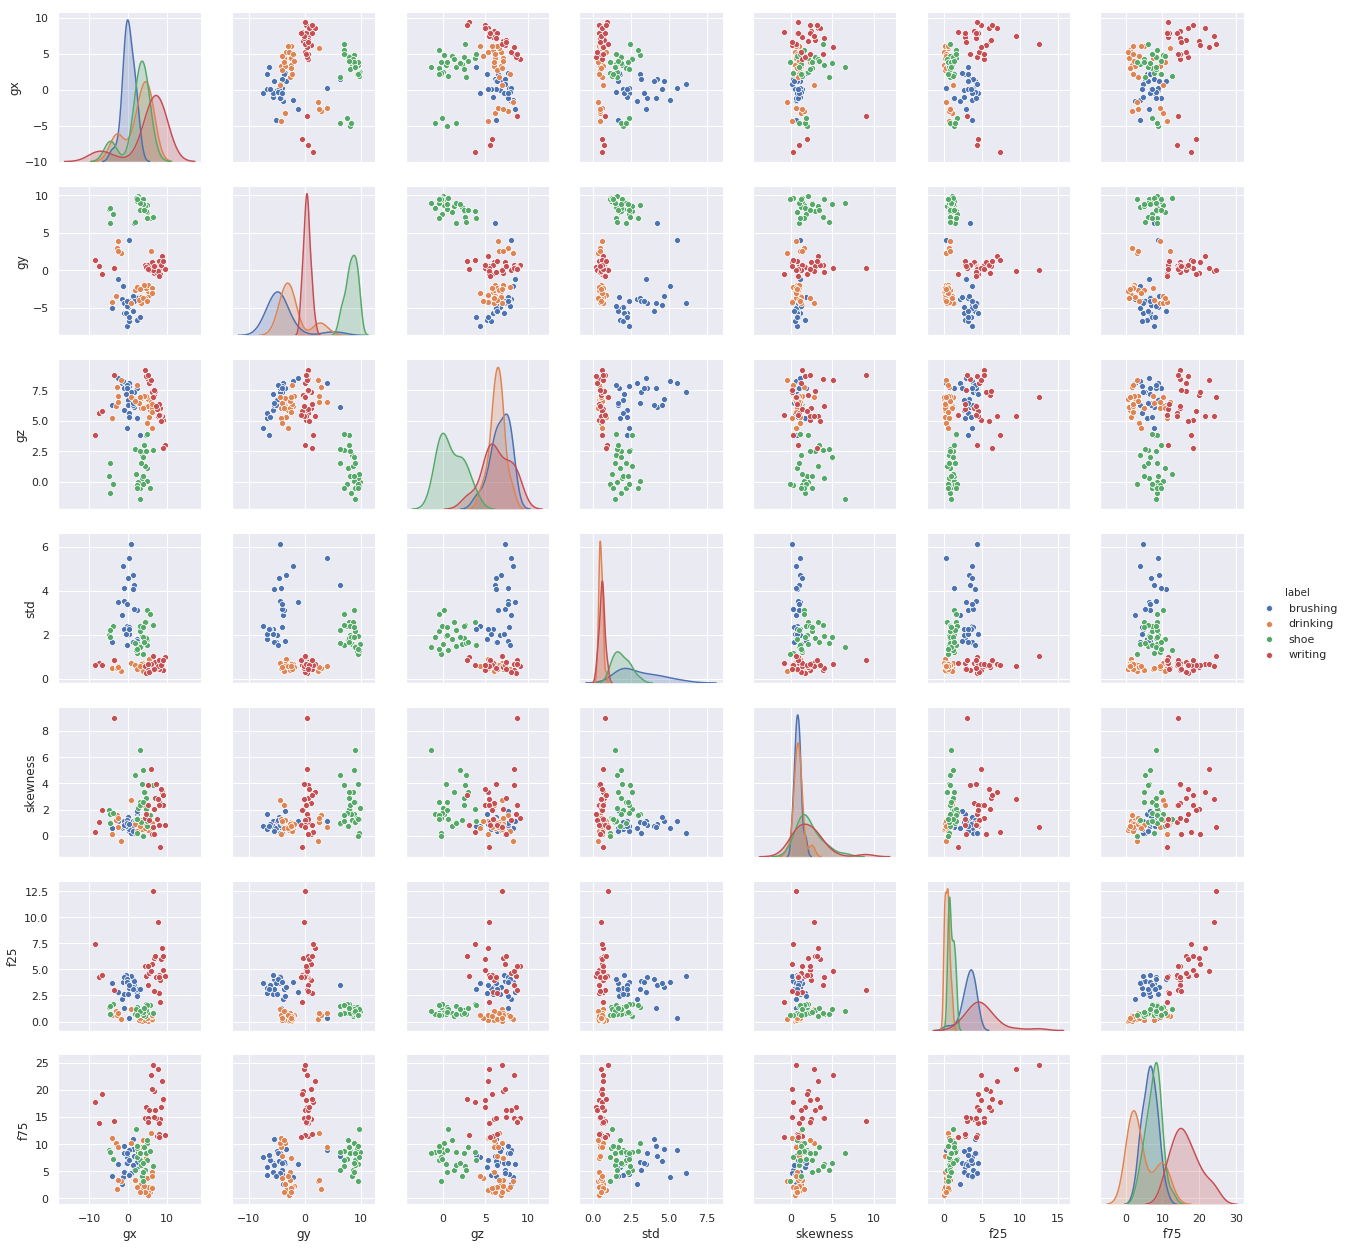

In [25]:
g = sns.pairplot(df.drop(['gx_abs', 'gy_abs', 'gz_abs'], axis=1), hue='label')
g.savefig('plots/first_pairplot.png', dpi=350)

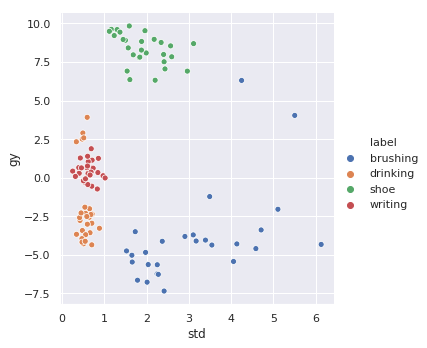

In [26]:
g = sns.relplot(x='std', y='gy', data=df, hue='label')
g.savefig('plots/first_pairplot_zoomed.png', dpi=350)
#sns.relplot(x='std', y='gy', data=_df16, hue='label')

## Train SVM
Fist create the necessary variables `X` and `y` and split them into train and test data.  

In [8]:
FEATURES_USED = ['std', 'gy']
SVM_PARAMETERS = {'kernel': 'linear'}
#FEATURES_USED = ['std', 'gy', 'gx', 'gz', 'skewness', 'f25', 'f75']
#SVM_PARAMETERS = {'kernel': 'poly'}

In [9]:
X = df[FEATURES_USED]
y = df.label == 'brushing'

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=1/3, random_state=0)

The actual training is done using [scikit-learn](https://scikit-learn.org/stable/).

In [10]:
clf = sk.svm.SVC(**SVM_PARAMETERS)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Visualize the trained Classifier

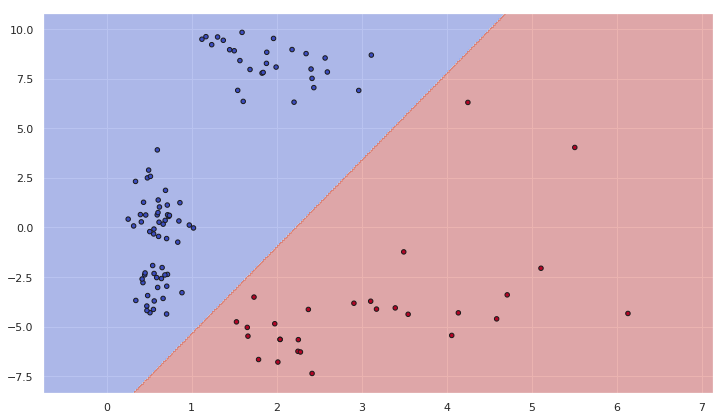

In [11]:
if len(FEATURES_USED) == 2:
    ax = visualization.plot_contours(X, y, clf)
ax.get_figure().savefig('plots/linear_decision_boundary.png')

### ROC & ROC_AUC

Area under ROC curve: 1.0


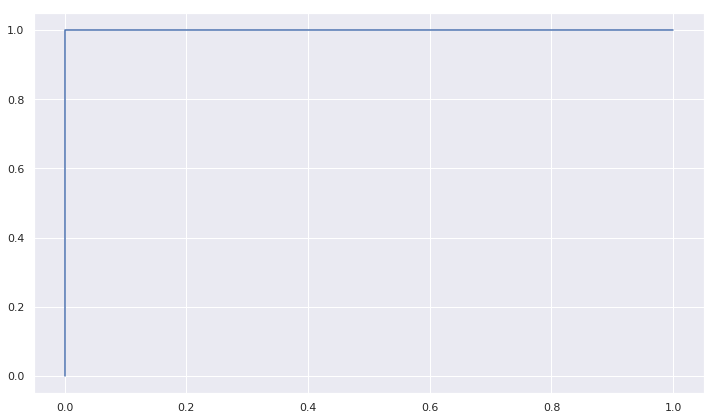

In [12]:
if len(FEATURES_USED) == 2:
    # ROC
    visualization.plot_roc(X_test, y_test, clf)

    # ROC-AUC
    roc_auc = sk.metrics.roc_auc_score(y, clf.decision_function(X))
    print('Area under ROC curve:', roc_auc)

### Confusion Matrix

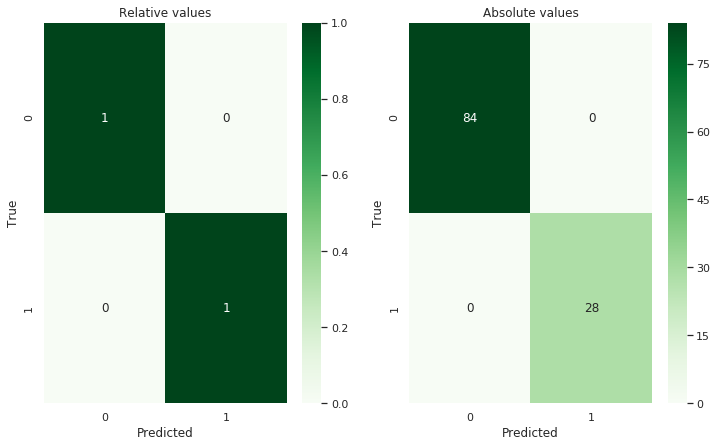

In [13]:
visualization.plot_confusion_matrix(y, clf.predict(X))

### Accuracy

In [14]:
print('2018 train metrics:')
visualization.print_metrics(y_train, clf.predict(X_train))
print('2018 test metrics:')
visualization.print_metrics(y_test, clf.predict(X_test))

2018 train metrics:
{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0}
2018 test metrics:
{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0}


## Detection on new data
The `testData.mat` file is structured differently to the files we trained on.

               x         y         z  label   activity
96174   2.626506  0.686747  9.240964      0  undefined
1577    9.108434 -1.228916  4.301205      0  undefined
72111   5.578313  2.385542  8.289157      3    writing
8993    4.313253  9.265060  4.277108      0  undefined
101366  7.506024 -1.771084  2.951807      0  undefined


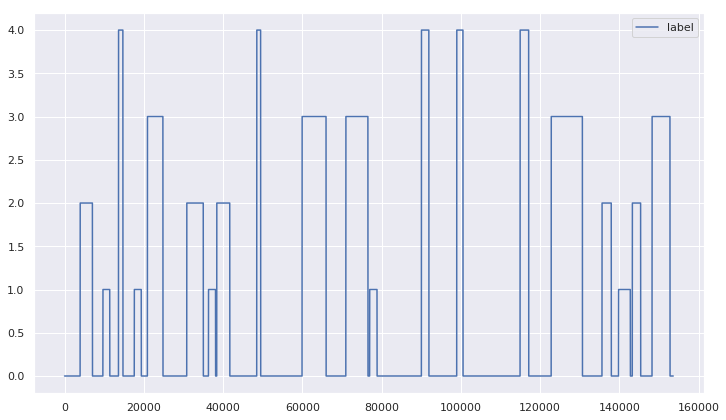

In [15]:
test_data = utils.load_testdata()
pprint(test_data.sample(5))
test_data.plot(y='label')

Make predictions on the `testData.mat` file. This consists of quite some steps, for more details look into `utils.py`.

In [16]:
import importlib; importlib.reload(utils)
y_predicted = utils.predict_on_streamed_data(clf, test_data, FEATURES_USED, window_size=20, window_step=2)

100%|█████████▉| 153497/153611 [01:53<00:00, 1425.00it/s]/home/nath/MEGA/Uni/ATHENS_2018_HealthInformatics/assignment/ATHENS2018/utils.py:216: RuntimeWarning: Mean of empty slice.
  final_prediction = bool(round(relevant_predictions.mean()))
/home/nath/MEGA/Uni/ATHENS_2018_HealthInformatics/assignment/ATHENS2018/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 153611/153611 [01:53<00:00, 1353.43it/s]


Present the predictions and the true values over time.

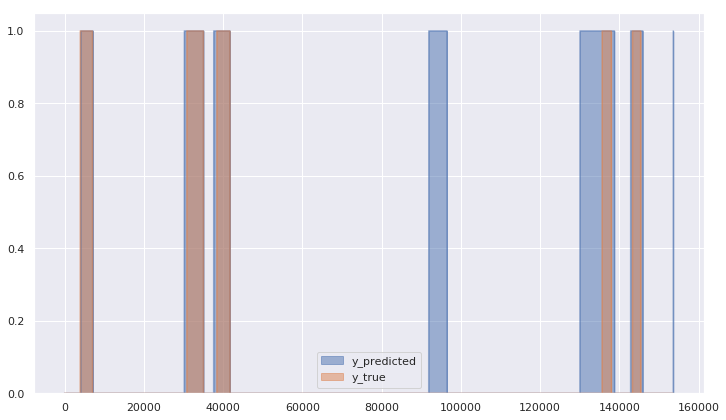

In [17]:
eval_df = pd.DataFrame({'y_predicted': y_predicted}, index=test_data.index)
eval_df['y_true'] = test_data['activity'] == 'brushing'
ax = eval_df.astype(int).plot(kind='area', stacked=False, alpha=0.5)
ax.get_figure().savefig('plots/linear_testdata_prediction.png')

### Stats on testData.mat

Metrics:
{'Accuracy': 0.9104946911354005,
 'Precision': 0.5220037288493333,
 'Recall': 0.9892666666666666}


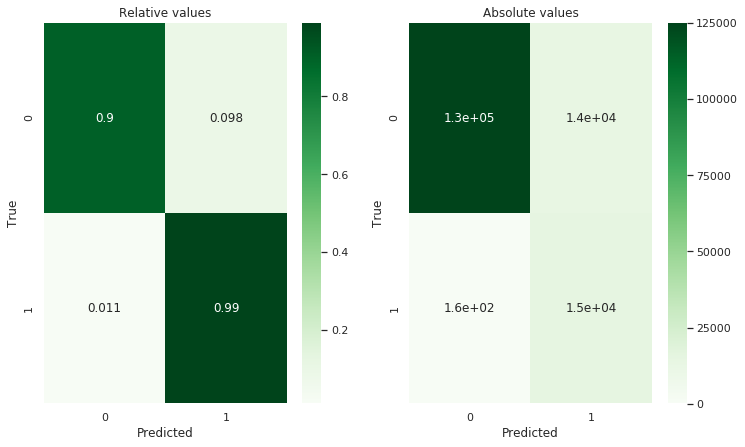

In [18]:
import importlib; importlib.reload(visualization)
# Confusion Matrix
visualization.plot_confusion_matrix(eval_df.y_true, eval_df.y_predicted)

# Metrics
metrics = {
    'Accuracy': sk.metrics.accuracy_score(eval_df.y_true, eval_df.y_predicted),
    'Precision': sk.metrics.precision_score(eval_df.y_true, eval_df.y_predicted),
    'Recall': sk.metrics.recall_score(eval_df.y_true, eval_df.y_predicted)
}
print('Metrics:')
pprint(metrics)

## Performance on 2016&2017 data

Metrics on the 2016 data:
{'Accuracy': 0.8, 'Precision': 0.6, 'Recall': 0.46153846153846156}
Metrics on the 2017 data:
{'Accuracy': 0.5, 'Precision': 0.0, 'Recall': 0.0}


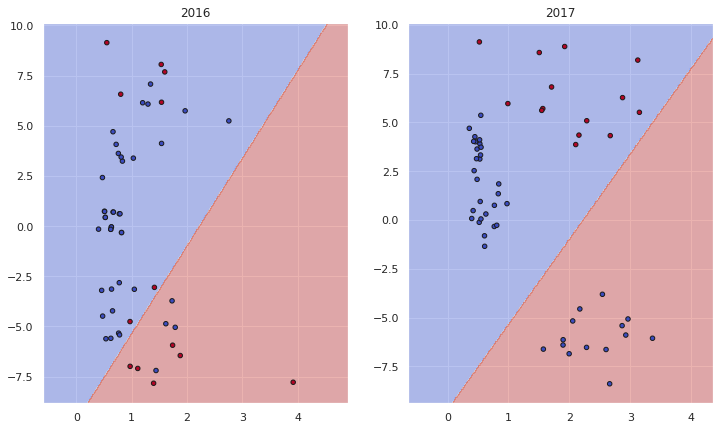

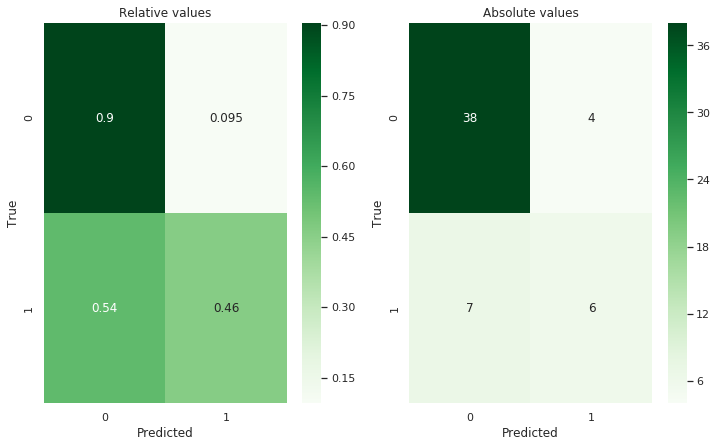

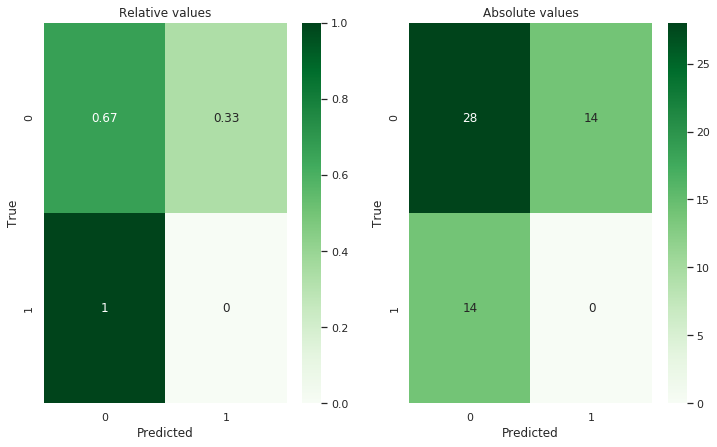

In [19]:
import importlib; importlib.reload(visualization)
visualization.results_on_years(clf, FEATURES_USED)

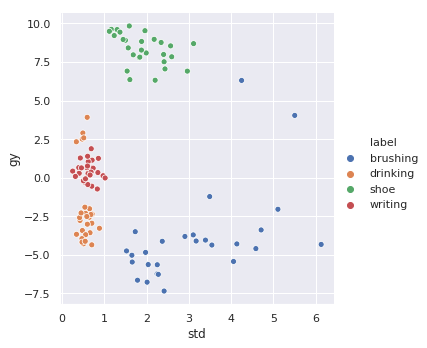

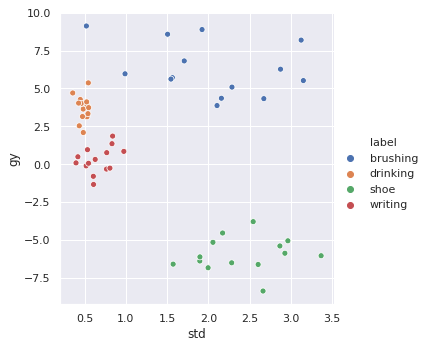

In [29]:
g = sns.relplot(x='std', y='gy', data=_df18, hue='label')
g = sns.relplot(x='std', y='gy', data=_df17, hue='label')

### Classifier trained on all 7 features

In [20]:
FEATURES_USED = ['std', 'gy', 'gx', 'gz', 'skewness', 'f25', 'f75', 'gy_abs', 'gx_abs', 'gz_abs']
#FEATURES_USED = ['std', 'gy', 'gx', 'gz', 'skewness', 'f25', 'f75']
SVM_PARAMETERS = {'kernel': 'poly'}

X = df[FEATURES_USED]
y = df.label == 'brushing'

#X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
#    X, y, test_size=1/3, random_state=0)
#clf = sk.svm.SVC(**SVM_PARAMETERS)
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Metrics on the 2016 data:
{'Accuracy': 0.8909090909090909,
 'Precision': 0.8888888888888888,
 'Recall': 0.6153846153846154}
Metrics on the 2017 data:
{'Accuracy': 0.75, 'Precision': 0.5, 'Recall': 0.5714285714285714}


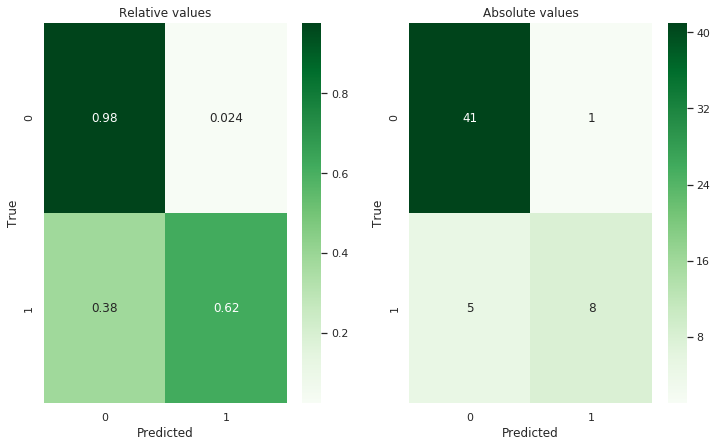

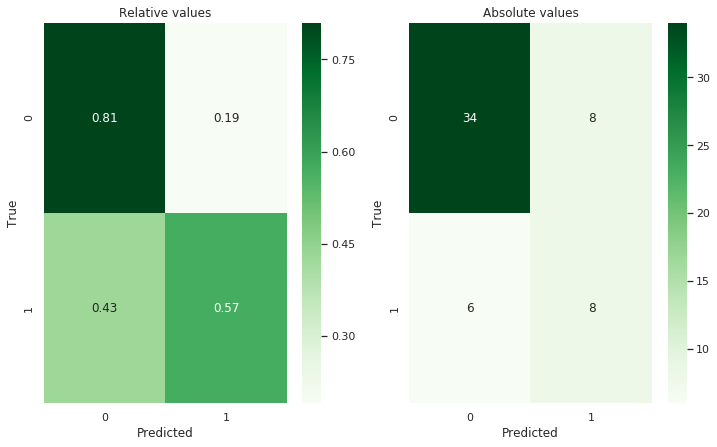

In [21]:
import importlib; importlib.reload(visualization)
visualization.results_on_years(clf, FEATURES_USED)

Evaluate on `testData.mat`

In [22]:
y_predicted = utils.predict_on_streamed_data(clf, test_data, FEATURES_USED, window_size=20, window_step=2)

100%|█████████▉| 153507/153611 [01:53<00:00, 1265.07it/s]/home/nath/MEGA/Uni/ATHENS_2018_HealthInformatics/assignment/ATHENS2018/utils.py:216: RuntimeWarning: Mean of empty slice.
  final_prediction = bool(round(relevant_predictions.mean()))
/home/nath/MEGA/Uni/ATHENS_2018_HealthInformatics/assignment/ATHENS2018/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 153611/153611 [01:53<00:00, 1356.52it/s]


{'Accuracy': 0.916405726152424,
 'Precision': 0.5443672680942008,
 'Recall': 0.883}


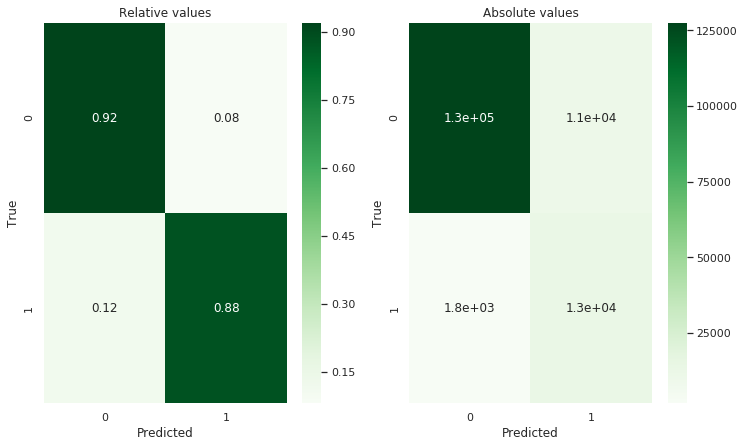

In [23]:
eval_df = pd.DataFrame({'y_predicted': y_predicted}, index=test_data.index)
eval_df['y_true'] = test_data['activity'] == 'brushing'

import importlib; importlib.reload(visualization)
# Confusion Matrix
visualization.plot_confusion_matrix(eval_df.y_true, eval_df.y_predicted)

# Metrics
visualization.print_metrics(eval_df.y_true, eval_df.y_predicted)

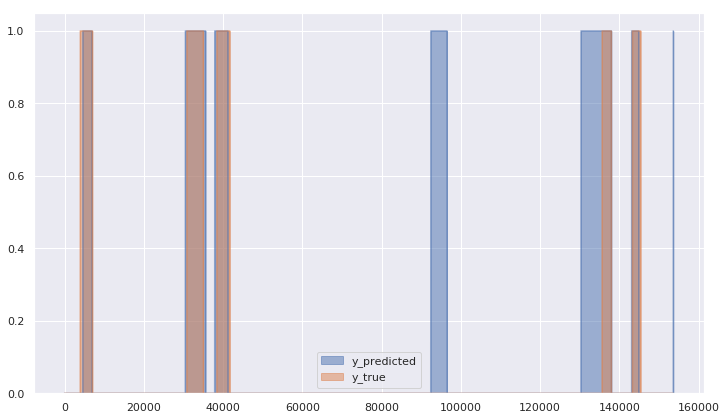

In [24]:
eval_df = pd.DataFrame({'y_predicted': y_predicted}, index=test_data.index)
eval_df['y_true'] = test_data['activity'] == 'brushing'
ax = eval_df.astype(int).plot(kind='area', stacked=False, alpha=0.5)
ax.get_figure().savefig('plots/full_testdata_prediction.png')